In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dipy
from dipy.reconst.ivim import IvimModel
import dipy.core.gradients as dpg
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data

In [2]:
fraw, fbval, fbvec = get_fnames('ivim')

In [3]:
sim_bvecs = dpg.generate_bvecs(6)

In [4]:
data = load_nifti_data(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs, b0_threshold=0)

In [5]:
sim_bvecs = np.vstack([sim_bvecs]* len(gtab.bvals[1:]))

In [6]:
sim_bvecs = np.vstack([np.array([[0, 0, 0]]), sim_bvecs])

In [7]:
sim_bvals = np.hstack(list([[gtab.bvals[1:][i]] * 6] for i in range(len(gtab.bvals[1:])))).squeeze()

In [8]:
sim_bvals = np.hstack([0, sim_bvals])

In [9]:
sim_bvals.shape

(121,)

In [10]:
sim_bvecs.shape

(121, 3)

In [11]:
sim_gtab = gradient_table(sim_bvals, sim_bvecs, b0_threshold=0)

$\frac{S}{S_0} = \beta e^{-b \theta^t Q^{*}, \theta} + (1- \beta) e^{-b \theta^t Q \theta}$


In [12]:
from dipy.reconst.dti import lower_triangular, from_lower_triangular

In [13]:
theta = sim_gtab.bvecs

In [14]:
def ivim_tensor(b, *params): 
    """ 
    
    """
    beta = params[0]
    Q = from_lower_triangular(np.array(params[1:7]))
    Q_star = from_lower_triangular(np.array(params[7:]))
    return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))
    

In [15]:
Q = lower_triangular(np.array([[0.0015, 0, 0], [0, 0.001, 0], [0, 0, 0.001]]))
Q_star = 10 * Q

#theta = np.array([[1, 0, 0]])
beta = 0.2

In [16]:
len(np.hstack((beta, Q, Q_star)))

13

In [17]:
params = np.hstack([beta, Q, Q_star])

In [18]:
np.array(params[1:7])

array([0.0015, 0.    , 0.001 , 0.    , 0.    , 0.001 ])

In [19]:
signal = ivim_tensor(sim_gtab.bvals, *params)

In [20]:
signal = signal+np.random.randn(signal.shape[0]) * 0.05

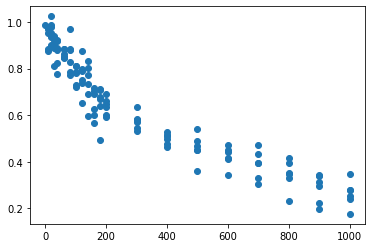

In [21]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [22]:
from scipy.optimize import curve_fit

In [23]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

In [24]:
popt

array([ 2.62340351e-01,  1.20515660e-03, -6.50535959e-06,  8.81768400e-04,
       -1.27762677e-06,  4.36832229e-06,  8.85704932e-04,  1.34981916e-02,
       -1.59978378e-03,  6.82251488e-03,  1.71830126e-03, -1.48146252e-04,
        7.29003656e-03])

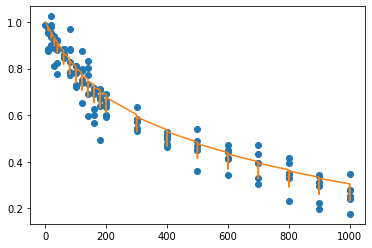

In [25]:
plt.plot(sim_gtab.bvals, signal, 'o')
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))

In [26]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [27]:
from dipy.reconst import dti

In [28]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.26234035096039526,
 (array([0.00120529, 0.00088846, 0.00087888]),
  array([[-0.99978761,  0.01442671,  0.01471723],
         [ 0.02016118,  0.53662506,  0.84357991],
         [ 0.00427245,  0.84369746, -0.53680195]])),
 (array([0.01427976, 0.00697458, 0.0063564 ]),
  array([[-0.94876295, -0.12442878,  0.29045883],
         [ 0.20825693,  0.44509608,  0.87092969],
         [-0.23765081,  0.88679589, -0.39637752]])))

In [29]:
from dipy.sims.voxel import multi_tensor

In [30]:
mevals = np.array([[0.001, 0.0005, 0.0005], 
                   [0.1, 0.01, 0.01]])

angles = [(90, 0), (90, 0)]

In [31]:
perfusion_fraction = 0.2

In [32]:
signal = multi_tensor(sim_gtab, mevals=mevals, snr=1000, fractions=[100 * (1-perfusion_fraction), 
                                                                    perfusion_fraction * 100])[0]

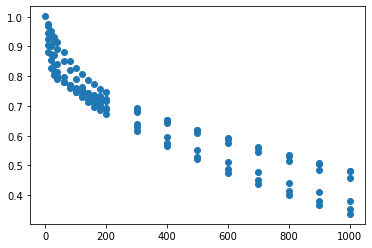

In [33]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [34]:
model = IvimModel(sim_gtab, fit_method="trr")

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:151: UserWarning: Bounds for this fit have been set from experiments and literature survey. To change the bounds, please input your bounds in model definition...
  warnings.warn(bounds_warning, UserWarning)


In [35]:
fit = model.fit(signal)

In [36]:
fit.D, fit.D_star, fit.perfusion_fraction

(array(0.00067979), array(0.02975597), array(0.17473471))

In [37]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

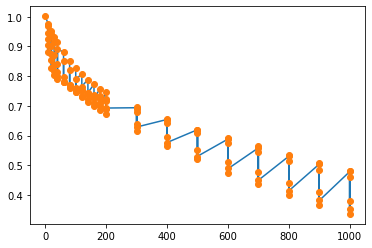

In [38]:
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))
plt.plot(sim_gtab.bvals, signal, 'o')

In [39]:
popt[0]

0.19977217727392

In [40]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [41]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.19977217727392,
 (array([0.00099947, 0.00050227, 0.00049972]),
  array([[-2.88707726e-03,  6.20020288e-01,  7.84580466e-01],
         [-3.89952766e-04,  7.84582978e-01, -6.20023708e-01],
         [ 9.99995756e-01,  2.09600567e-03,  2.02337305e-03]])),
 (array([0.0984702 , 0.01057545, 0.01006831]),
  array([[-0.99994484, -0.00706525,  0.00777231],
         [ 0.00957925, -0.3098793 ,  0.95072765],
         [-0.00430865,  0.95074965,  0.30992988]])))

In [42]:
evals_Q_hat = dti.decompose_tensor(Q_hat)[0]

In [43]:
np.mean(evals_Q_hat)

0.0006671499181518371

In [44]:
evals_Q_star_hat = dti.decompose_tensor(Q_star_hat)[0]

In [45]:
np.mean(evals_Q_star_hat)

0.03970465278229195

In [46]:
pdd_Q_hat = dti.decompose_tensor(Q_hat)[1][0]

In [47]:
pdd_Q_hat_star =  dti.decompose_tensor(Q_star_hat)[1][0]

In [48]:
pdd_Q_hat, pdd_Q_hat_star

(array([-0.00288708,  0.62002029,  0.78458047]),
 array([-0.99994484, -0.00706525,  0.00777231]))

In [49]:
np.rad2deg(np.arccos(np.dot(pdd_Q_hat, pdd_Q_hat_star)))

89.73619101006763

In [50]:
dti.fractional_anisotropy(evals_Q_star_hat)

0.8855060894872867

In [51]:
dti.fractional_anisotropy(evals_Q_hat)

0.4068805030263805

In [52]:
dti.mean_diffusivity(evals_Q_hat)

0.0006671499181518371

In [53]:
dti.mean_diffusivity(mevals[0])

0.0006666666666666666

In [54]:
dti.mean_diffusivity(evals_Q_star_hat)

0.03970465278229195

In [55]:
dti.mean_diffusivity(mevals[1])

0.04

In [149]:
from dipy.reconst.base import ReconstFit, ReconstModel
from dipy.reconst.multi_voxel import multi_voxel_fit
from dipy.reconst.dti import TensorModel, TensorFit, decompose_tensor, from_lower_triangular

In [192]:
class IvimTensorModel(ReconstModel):
    def __init__(self, gtab, split_b_D=400.0, bounds=[]):
        ReconstModel.__init__(self, gtab)
        self.split_b_D = split_b_D
        self.bounds = bounds
        # Use two separate tensors for initial estimation:
        self.dti = TensorModel(self.gtab)
        
        self.split_idx = np.where(gtab.bvals >= self.split_b_D)    
        self.perfusion_gtab = gradient_table(self.gtab.bvals[self.split_idx],
                                             self.gtab.bvecs[self.split_idx])
        
        self.perfusion_model = TensorModel(self.perfusion_gtab)

    def model_eq1(self, b, *params): 
        """ 
        The model with fixed perfusion fraction
        """
        beta = self.perfusion_fraction
        Q = from_lower_triangular(np.array(params[:6]))
        Q_star = from_lower_triangular(np.array(params[6:]))
        return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))

    def model_eq2(self, b, *params): 
        """ 
        The full model, including perfusion fraction
        """
        beta = params[0]
        Q = from_lower_triangular(np.array(params[1:7]))
        Q_star = from_lower_triangular(np.array(params[7:]))
        return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))

    
    def fit(self, data, mask=None):
        """ 
        For now, we assume that data is from a single voxel, and we'll generalize later
        """
        # Fit a tensor to the entire data and data just up to split_b_D
        self.dti_fit = self.dti.fit(data, mask)
        self.q_initial = lower_triangular(self.dti_fit.quadratic_form)
        
        perfusion_data = data[self.split_idx]
        self.perfusion_fit = self.perfusion_model.fit(perfusion_data, mask)
        self.q_star_initial = lower_triangular(self.perfusion_fit.quadratic_form).squeeze()
        fractions_for_probe = np.arange(0, 0.5, 0.05)
        self.fits = np.zeros((fractions_for_probe.shape[0], 12))
        self.errs = np.zeros(fractions_for_probe.shape[0])
        self.beta = np.zeros(fractions_for_probe.shape[0])
        initial = np.hstack([self.q_initial, self.q_star_initial])
        # Instead of estimating perfusion_fraction directly, we start by finding 
        # a perfusion fraction that works for the other parameters
        for ii, perfusion_fraction in enumerate(fractions_for_probe):
            self.perfusion_fraction = perfusion_fraction
            popt, pcov = curve_fit(self.model_eq1,  self.gtab.bvals, data, p0=initial)
            err = np.sum(np.power(self.model_eq1(self.gtab.bvals, *popt) - data, 2))
            self.fits[ii] = popt
            self.errs[ii] = err
            self.beta[ii] = perfusion_fraction

        min_err = np.argmin(self.errs)
        initial = np.hstack([self.beta[min_err], self.fits[min_err]])
        popt, pcov = curve_fit(self.model_eq2,  self.gtab.bvals, data, p0=initial)
        return IvimTensorFit(self, popt)
        
                            
class IvimTensorFit(ReconstFit):
    def __init__(self, model, model_params):
        self.model = model
        self.model_params = model_params
        tensor_evals, tensor_evecs = decompose_tensor(from_lower_triangular(self.model_params[1:7]))
        tensor_params = np.hstack([tensor_evals, tensor_evecs.ravel()])
        perfusion_evals, perfusion_evecs = decompose_tensor(from_lower_triangular(self.model_params[7:]))
        perfusion_params = np.hstack([perfusion_evals, perfusion_evecs.ravel()])
        self.tensor_fit = TensorFit(self.model.dti, tensor_params)
        self.perfusion_fit = TensorFit(self.model.perfusion_model, perfusion_params)
        self.perfusion_fraction = model_params[0]

In [193]:
itm = IvimTensorModel(sim_gtab)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/core/gradients.py:297: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (400.0).
  ({1}).".format(b0_threshold, bvals.min()))


In [194]:
signal.shape, sim_gtab.bvals.shape

((121,), (121,))

In [195]:
itf = itm.fit(signal)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [196]:
itf.tensor_fit.fa, itf.perfusion_fit.fa

(0.40688050452532776, 0.8855060870219746)

In [198]:
itf.tensor_fit.evals, itf.perfusion_fit.evals, itf.perfusion_fraction

(array([0.00099947, 0.00050227, 0.00049972]),
 array([0.09847019, 0.01057545, 0.01006831]),
 0.19977217942737213)

In [200]:
itf.tensor_fit.directions, itf.perfusion_fit.directions

(array([[-2.88699001e-03, -3.89755534e-04,  9.99995757e-01]]),
 array([[-0.99994484,  0.0095792 , -0.00430871]]))

In [207]:
fracs_discovered = []
for snr in [1, 10, 100, 1000]:
    for perfusion_fraction in [0.01, 0.05, 0.1, 0.15, 0.2]:
        signal = multi_tensor(sim_gtab, mevals=mevals, snr=snr, 
                              fractions=[100 * (1-perfusion_fraction), 
                              perfusion_fraction * 100])[0]
        try:
            itf = itm.fit(signal)
            fracs_discovered.append(itf.perfusion_fraction)
        except RuntimeError:
            fracs_discovered.append(np.nan)
            

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


In [208]:
fracs_discovered

[-0.925568674950371,
 1.9057655463402055e-06,
 1.5948479309872624e-06,
 nan,
 0.3499841843439206,
 nan,
 nan,
 0.1402497123824144,
 nan,
 nan,
 0.4934995366487066,
 0.9528192741487252,
 0.8998964561615516,
 0.1540018546671407,
 0.1963002169708695,
 0.00989662958150657,
 0.9498473758626119,
 0.8998756911416277,
 0.1494901510341111,
 0.20045629393318976]